In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from beta_irt.visualization.plots import newline
from beta_irt.visualization.plots import plot_parameters
from irt import beta_irt
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Data set

In [37]:
# Path
path_data = './data/'
path_uci = './data/UCI - 45/'

# Name of data set
name = 'mpg'

# Read csv
data = pd.read_csv(path_uci + name + '.csv')
data = data.dropna()

Parameters:

In [38]:
rd = 42
noise_std = 14
max_std = 14

## Pre processing

Variable selection:

In [39]:
X = data.iloc[:, 1:-3].values
y = data.iloc[:, 0]

Split data:

In [40]:
# Split data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = rd)

Principal Component Analysis:

In [41]:
# PCA
pca = PCA(n_components= 1)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Plot train/test split

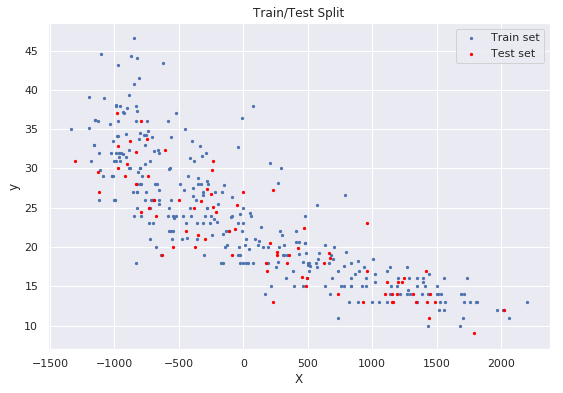

In [42]:
plt.figure(figsize=(9, 6))
plt.scatter(X_train, y_train, label='Train set', s=5)
plt.scatter(X_test, y_test, label='Test set', c='red', s=5)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Train/Test Split')
plt.legend()
plt.savefig('./Results_IRT/' + name + '/dataset.png')

This part is where data for BIRT models are generated.

In [8]:
# Regression Models
models = [LinearRegression(), BayesianRidge(), svm.SVR(kernel= 'linear'), svm.SVR(kernel = 'rbf', gamma= 'scale', C = 5),\
     KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),\
          AdaBoostRegressor(), MLPRegressor(max_iter=1000, solver= 'lbfgs'), MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, solver= 'adam')]

# Generate abilities/parameters for BIRT and other info.
Irt = IRTModel(models= models)
Irt.irtMatrix(X_train = X_train, y_train = y_train, X_test= X_test, y_test= y_test,
              noise_std = noise_std, normalize= True, base_models= True, name= name, rd= rd)

In [9]:
Irt.irt_matrix.head()

,LinearRegression,BayesianRidge,SVR,SVR,KNeighborsRegressor,DecisionTreeRegressor,RandomForestRegressor,AdaBoostRegressor,MLPRegressor,MLPRegressor,Optimal,Medium,Worst
203,0.906296,0.905014,0.808323,0.711264,0.873132,0.859135,0.889969,0.838540,0.944842,0.735446,0.944842,0.500091,0.500091
266,0.746988,0.747943,0.719036,0.669054,0.583574,0.809445,0.718050,0.605011,0.616859,0.467932,0.809445,0.500013,0.467932
152,0.641446,0.642506,0.721901,0.916566,0.877958,0.853360,0.962447,0.931283,0.992215,0.770884,0.992215,0.500043,0.500043
9,0.474720,0.475833,0.777322,0.780636,0.896068,0.535058,0.765965,0.876060,0.963953,0.418672,0.963953,0.500024,0.418672
233,0.632542,0.632180,0.583487,0.676255,0.928295,0.873798,0.910232,0.886662,0.897996,0.706231,0.928295,0.500057,0.500057


Plotting limits

In [10]:
xlim = [min(X_test), max(X_test)]
ylim = [min(y_test)- 3*max_std, max(y_test)+ 3*max_std]

# ICC

It is required to run 'betairt_test.py' with the same data generated above.

In [11]:
name = name + '_s' + str(len(y_test)) + '_f' + str(noise_std) + '_sd' + str(rd)

In [12]:
os.chdir('./beta_irt/')
%run -i betairt_test.py {'irt_data_'+ name +'.csv'}
os.chdir('..')

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.

Item-Response Matrix:

In [13]:
path = './beta_irt/results/'
folder = name.split('_')[0] + '/'
output = './Results_IRT/'+ folder+ 'noise_' + name.split('_')[-2][1:] + '/'

In [14]:
irt = pd.read_csv('./beta_irt/irt_data_' + name + '.csv')
X_pc1 = pd.read_csv('./beta_irt/xtest_' + name + '.csv').iloc[:,0].values.reshape(-1,1)
noise = pd.read_csv('./beta_irt/xtest_' + name + '.csv').iloc[:,1].values
y_test += noise
abilities = pd.read_csv(path + folder + 'irt_ability_vi_'+ name +'_am1@0_as1@0.csv')
ind = list(y_test.index)
parameters = pd.read_csv(path + folder + 'irt_parameters_vi_'+ name +'_am1@0_as1@0.csv')
parameters.index = ind
irt.index = ind

Parameters:

In [15]:
difficulty = parameters.iloc[:,0].values
discrimination = parameters.iloc[:,1].values

In [16]:
ab = np.linspace(0.0001, 0.9999, 200)

## Plot parameters

In [17]:
concat = np.concatenate((X_test, y_test.values.reshape(-1,1)), axis = 1)

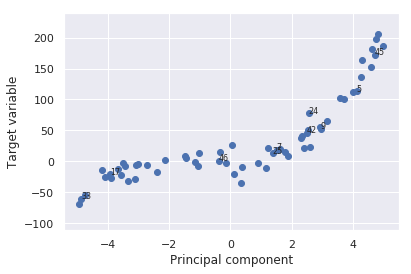

In [18]:
plt.scatter(concat[:,0],concat[:,1])
plt.xlabel('Principal component')
plt.ylabel('Target variable')
plt.ylim(ylim)
if noise_std == 0:
    plt.savefig('./Results_IRT/' + name.split('_')[0] + '/noise_' + str(noise_std) + '/original.png')
for i, txt in enumerate(ind):
    if txt <50:
        plt.text(concat[i,0],concat[i,1], str(txt), fontsize=8)
#     plt.text(concat[i,0],concat[i,1], str(txt), fontsize=8)

In [19]:
print(parameters.sort_values(by= 'difficulty', ascending= True).head())
print(parameters.sort_values(by= 'discrimination', ascending= True).head())

     difficulty  discrimination
92     0.275515        0.614859
234    0.282614        0.732951
165    0.284963        0.568592
104    0.287787        0.672010
5      0.294578        0.795641
     difficulty  discrimination
203    0.361801        0.122728
157    0.571531        0.175972
237    0.585928        0.212100
7      0.520195        0.215874
278    0.521099        0.244645


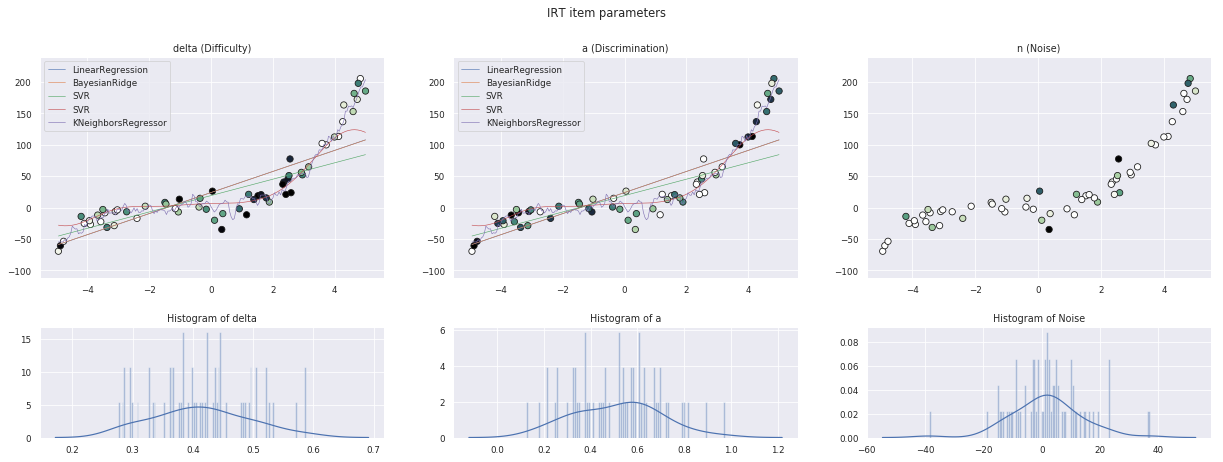

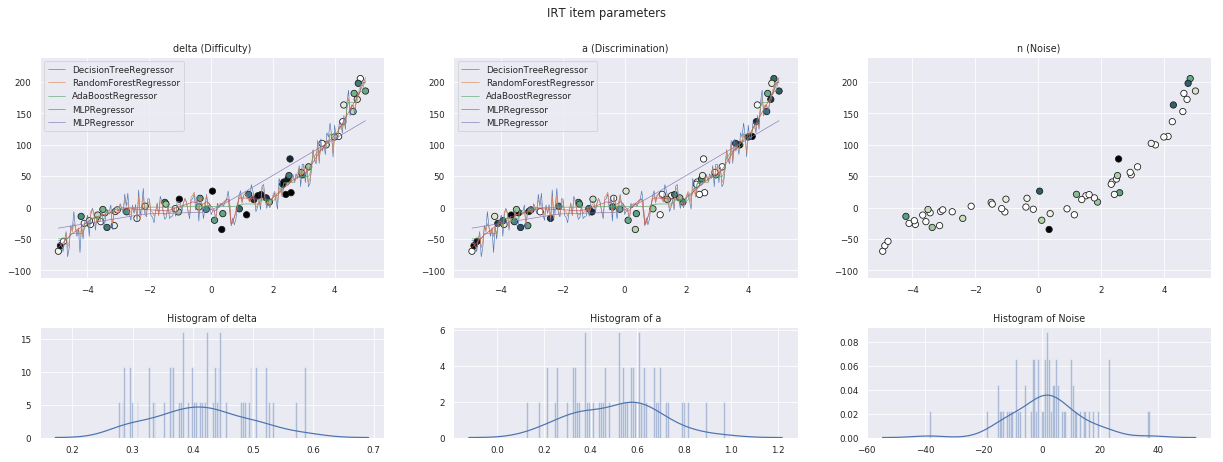

In [20]:
for i, l in enumerate([slice(0, 5, 1), slice(5, 10, 1)]):
    if noise_std > 0:
        f = plot_parameters(concat, delta = difficulty, a = discrimination, noise = noise, models= Irt.models[l], ylim= ylim)
    else:
        f = plot_parameters(concat, delta = difficulty, a = discrimination, models= Irt.models[l], ylim = ylim)
    f.savefig('./Results_IRT/' + name.split('_')[0] + '/noise_' + str(noise_std) + '/params_'+str(i+1)+'.png')

In [21]:
chosen_i = [278, 203, 73, 237]

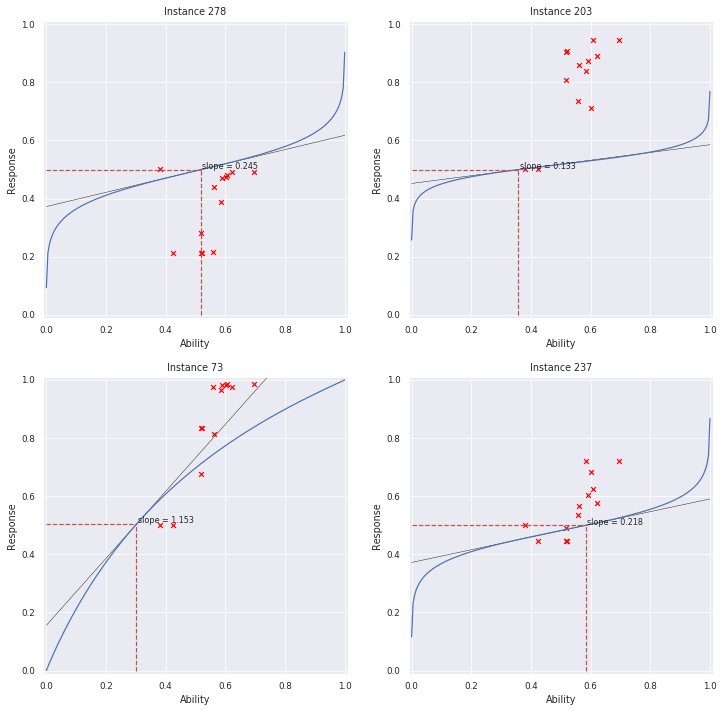

In [22]:
plt.figure(figsize=(12, 12))
for sub, i in enumerate(chosen_i):
    plt.subplot(2, 2, sub+1)
    par = parameters.loc[i,:].values
    diff = par[0]
    disc = par[1]
    E = [beta_irt(x, diff, disc) for x in ab]
    middle = np.where(np.array(E)>0.499)[0][:2]
    p1 = [ab[middle[0]], E[middle[0]]]
    p2 = [ab[middle[1]], E[middle[1]]]
    newline(p1,p2)
    slope = (E[middle[1]] - E[middle[0]])/(ab[middle[1]] - ab[middle[0]])
    plt.text(p2[0], p2[1], 'slope = '+str(round(slope, 3)),fontsize=8)
    plt.plot(ab, E,)
    plt.plot([ab[middle[0]], ab[middle[0]]],[0, E[middle[0]]], '--r')
    plt.plot([0, ab[middle[0]]],[E[middle[0]], E[middle[0]]], '--r')
    plt.scatter(abilities['ability'].values[:-1], irt.loc[irt.index == i].values[0], marker= 'x', c = 'red')
    plt.ylabel('Response')
    plt.xlabel('Ability')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('Instance ' + str(i))
plt.savefig('./Results_IRT/' + name.split('_')[0] + '/noise_' + str(noise_std) + '/instances.png')

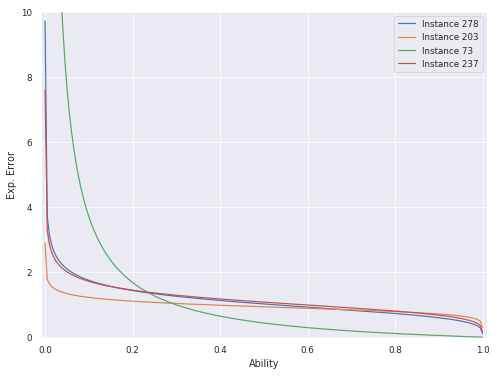

In [23]:
plt.figure(figsize=(8, 6))
for sub, i in enumerate(chosen_i):
#     plt.subplot(2, 2, sub+1)
    par = parameters.loc[i,:].values
    diff = par[0]
    disc = par[1]
    E = np.array([beta_irt(x, diff, disc) for x in ab])
    Error = (1 - E)/E
    plt.plot(ab, Error, label = 'Instance ' + str(i))
#     plt.plot([ab[middle[0]], ab[middle[0]]],[0, E[middle[0]]], '--r')
#     plt.plot([0, ab[middle[0]]],[E[middle[0]], E[middle[0]]], '--r')
    err = irt.loc[irt.index == i].values[0]
#     plt.scatter(abilities['ability'].values[:-1], (1-err)/err, marker= 'x', c = 'red')
    plt.ylabel('Exp. Error')
    plt.xlabel('Ability')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 10.01])
#     plt.title('')
plt.legend()
plt.savefig('./Results_IRT/' + name.split('_')[0] + '/noise_' + str(noise_std) + '/error_ability.png')

## MAE x Ability

In [24]:
mae = np.zeros(len(abilities)-1)
err_rel = np.absolute(y_test - y_test.mean())
for i, mod in enumerate(abilities.iloc[:-1, 0]):
    for j, rel in enumerate(err_rel):
        y = irt.iloc[j, i]
        mae[i] = mae[i] + ((1 - y)/y)*rel
mae = mae/len(y_test)
mae = np.delete(mae, -1)

In [25]:
mdls = ['LR', '  Bayes', ' SVR - Linear', ' SVR - Rbf', 'KNR', 'DT', 'RF', 'AdaB', 'MLP (100)', 'MLP (50-50)', 'Optimal', 'Medium']
c_n = 'C0'
c_e = 'red'
color = [c_n, c_n,c_n,c_n,c_n,c_n,c_n,c_n,c_n,c_n,c_e,c_e]

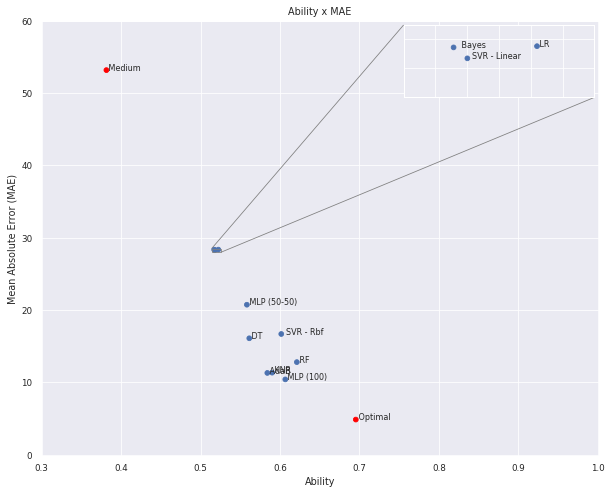

In [40]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes()
# ax.plot(overview_data_x, overview_data_y)

ax.scatter(abilities.iloc[:-2, 1], mae, c= color)

ax.set_ylabel('Mean Absolute Error (MAE)')
ax.set_xlabel('Ability')
ax.set_xlim([0.299, 1.001])
ax.set_ylim([-.1, 60])
ax.set_title('Ability x MAE')

axins = zoomed_inset_axes(ax, 20, loc=1) # zoom-factor: 2.5, location: upper-left
axins.scatter(abilities.iloc[:-2, 1], mae, c= color)

#IMPORTANT LINE (SPECIFY LIMITS OF ZOOM)#
x1, x2, y1, y2 = 0.514, 0.526, 28, 28.5
#########################################

for i, txt in enumerate(mdls):
    if ( ((abilities.iloc[i, 1] > x1) & (abilities.iloc[i, 1] < x2) & (mae[i] > y1) & (mae[i] < y2)) ):
        axins.text(abilities.iloc[i, 1], mae[i], ' '+txt, fontsize=8)
    else:
        ax.text(abilities.iloc[i, 1], mae[i], ' '+txt, fontsize=8)
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.savefig('./Results_IRT/' + name.split('_')[0] + '/noise_' + str(noise_std) + '/mae_ability.png')
plt.show()

Moving IRT files to 'Results_IRT' folder:

In [ ]:
!mv {'./beta_irt/irt_data_' + name + '.csv'} {'./Results_IRT/' + name.split('_')[0] + '/noise_' + str(noise_std)+'/'}
!mv {'./beta_irt/xtest_' + name + '.csv'} {'./Results_IRT/' + name.split('_')[0] + '/noise_' + str(noise_std)+'/'}
!mv {path + folder + 'irt_ability_vi_'+ name +'_am1@0_as1@0.csv'} {'./Results_IRT/' + name.split('_')[0] + '/noise_' + str(noise_std)+'/'}
!mv {path + folder + 'irt_parameters_vi_'+ name +'_am1@0_as1@0.csv'} {'./Results_IRT/' + name.split('_')[0] + '/noise_' + str(noise_std)+'/'}